In [1]:
!git clone https://github.com/katyafilimoshina/tsc_msc_dl.git
!pip install pyro-ppl

Cloning into 'tsc_msc_dl'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 30 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (30/30), 1.14 MiB | 8.13 MiB/s, done.
Resolving deltas: 100% (5/5), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 9.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl 

In [2]:
import sys
sys.path.append("/content/tsc_msc_dl/")

In [4]:
import torch
from torch import nn, optim
from torch.nn import KLDivLoss
from torch.distributions import MultivariateNormal as MNormal
from torch.distributions import Categorical, Normal

import pyro
from pyro.infer import MCMC, HMC as pyro_hmc, NUTS as pyro_nuts

from tqdm.notebook import tqdm, trange
import numpy as np

import matplotlib.pyplot as plt

from distributions import Funnel, Banana
from samplers import ISIR, NUTS, HMC

# MSC
Example with Normal distributions

In [5]:
from torch.optim.lr_scheduler import StepLR


# KL we try to minimize
def KL_div(log_p, log_q, eps=1e-7):
    l = torch.exp(log_p) * (log_p - log_q)
    return l.sum()


# define distributions
dim = 2
# define target
target =  MNormal(2 * torch.ones(dim), 3 * torch.eye(dim)) # Banana(b=0.02, dim=dim)
# define learnable parameters of proposal
# Pass to proposal like: proposal = MNormal(**learnable_params)
learnable_params = nn.ParameterDict({
    'loc': nn.Parameter(torch.zeros(dim), requires_grad=True),
    'covariance_matrix' : nn.Parameter(torch.eye(dim), requires_grad=True)
})


# define params for chain
N_CHAINS = 2
N_SAMPLES = 100
BURN_IN = 100

# optimizer
optimizer = optim.AdamW(lr=1e-1, params=learnable_params.parameters())
# decay lr: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR
scheduler = StepLR(optimizer, 1, gamma=1 - 1e-4)

# MSC iteration
n_iter = 100

loss_arr = []
kl_arr = []


for i in tqdm(range(n_iter)):

    optimizer.zero_grad()

    # define proposal with new params
    proposal = MNormal(**learnable_params)


    # sample from it
    with torch.no_grad():
        chains, _ = ISIR(
        proposal.sample((N_CHAINS, )),
        target,
        proposal,
        N_SAMPLES,
        BURN_IN,
        n_particles=100)

        # функция тупая и не пашет с одной цепью
        chain = chains[:, 0]

        # chains, _ = NUTS(
        # proposal.sample((N_CHAINS,)),
        # target,
        # N_SAMPLES,
        # BURN_IN,
        # )

    # get
    log_p = target.log_prob(chain)
    log_q = proposal.log_prob(chain)

    loss = (-1 * torch.exp(log_p) * log_q).sum()
    loss.backward()

    optimizer.step()

    scheduler.step()

    with torch.no_grad():
        loss_arr.append(loss.detach().item())
        kl_arr.append(KL_div(log_p, log_q))

  0%|          | 0/100 [00:00<?, ?it/s]

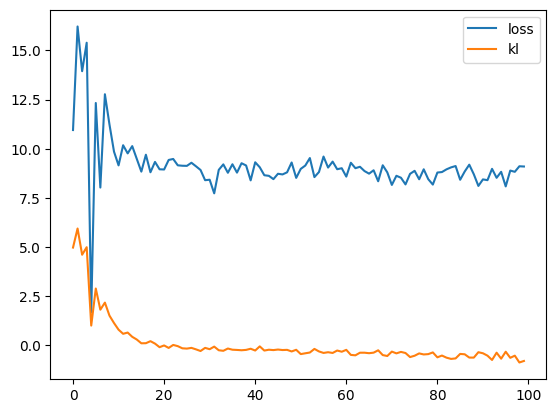

In [6]:
plt.plot(loss_arr, label='loss')
plt.plot(kl_arr, label='kl')
plt.legend()
plt.show()

Now let's draw what we sampled

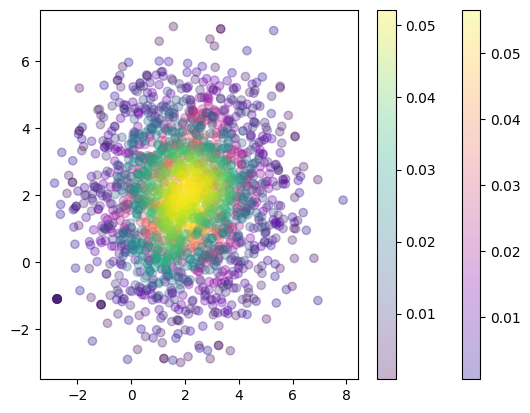

In [8]:
from scipy.stats import gaussian_kde

# Now target
points = target.sample((1000,))

# Generate points from distribution
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='plasma', alpha=0.3)
plt.colorbar()

chains, _ = ISIR(
        proposal.sample((2, )),
        target,
        proposal,
        1000,
        BURN_IN,
        n_particles=100)

# Generate points from distribution
points = chains[:, 0]
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='viridis', alpha=0.3)
plt.colorbar()

plt.show()
plt.close()

## Banana

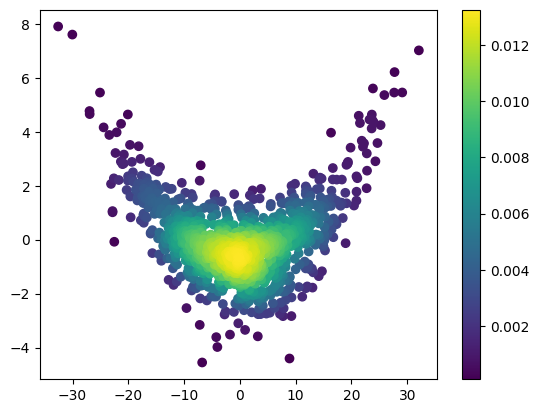

In [9]:
target =  Banana(b=8e-3, dim=dim)
target.visualize_dist()

  0%|          | 0/2000 [00:00<?, ?it/s]

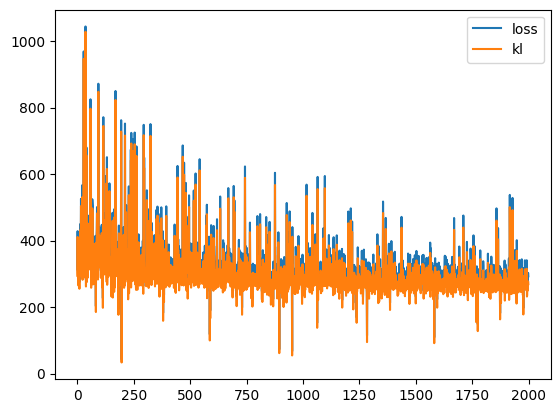

In [10]:
# define distributions
dim = 2
# define target
target = Banana(b=8e-3, dim=dim)
# define learnable parameters of proposal
# Pass to proposal like: proposal = MNormal(**learnable_params)
learnable_params = nn.ParameterDict({
    'loc': nn.Parameter(torch.zeros(dim), requires_grad=True),
    'covariance_matrix' : nn.Parameter(torch.eye(dim) + 1e-3, requires_grad=True)
})


# define params for chain
N_CHAINS = 2
N_SAMPLES = 100
BURN_IN = 100

# optimizer
optimizer = optim.AdamW(lr=3e-2, params=learnable_params.parameters())
# decay lr: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR
scheduler = StepLR(optimizer, 1, gamma=1 - 1e-3)

# MSC iteration
n_iter = 2000

loss_arr = []
kl_arr = []


for i in tqdm(range(n_iter)):

    optimizer.zero_grad()

    # define proposal with new params
    proposal = MNormal(**learnable_params)


    # sample from it
    with torch.no_grad():
        chains, _ = ISIR(
        proposal.sample((N_CHAINS, )),
        target,
        proposal,
        N_SAMPLES,
        BURN_IN,
        n_particles=100)

        # функция тупая и не пашет с одной цепью
        chain = chains[:, 0]

        # chains, _ = NUTS(
        # proposal.sample((N_CHAINS,)),
        # target,
        # N_SAMPLES,
        # BURN_IN,
        # )

    # get
    log_p = target.log_prob(chain)
    log_q = proposal.log_prob(chain)

    loss = (-1 * torch.exp(log_p) * log_q).sum()
    loss.backward()

    optimizer.step()

    scheduler.step()

    with torch.no_grad():
        loss_arr.append(loss.detach().item())
        kl_arr.append(KL_div(log_p, log_q))


plt.plot(loss_arr, label='loss')
plt.plot(kl_arr, label='kl')
plt.legend()
plt.show()

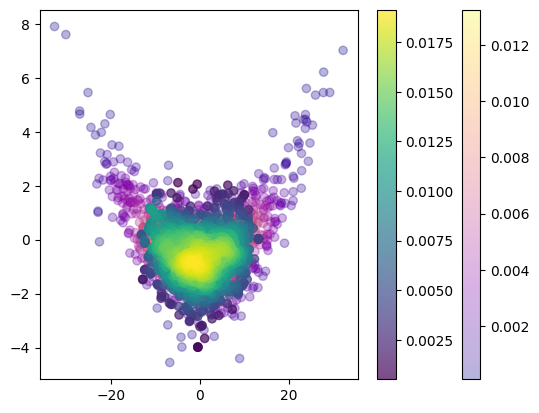

In [11]:
# Now target
points = target.sample(1000)

# Generate points from distribution
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='plasma', alpha=0.3)
plt.colorbar()

chains, _ = ISIR(
        proposal.sample((2, )),
        target,
        proposal,
        1000,
        BURN_IN,
        n_particles=100)

# Generate points from distribution
points = chains[:, 0]
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='viridis', alpha=0.7)
plt.colorbar()

plt.show()
plt.close()

## Funnel

  0%|          | 0/1000 [00:00<?, ?it/s]

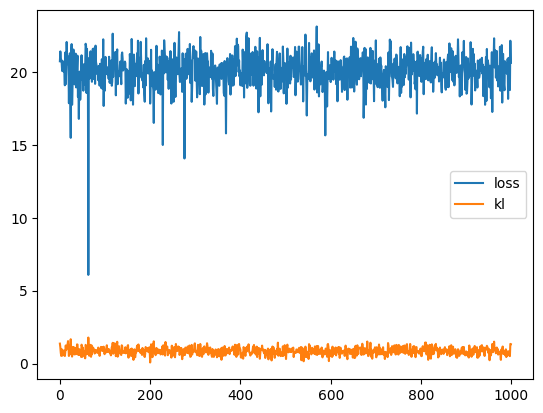

In [ ]:
# define distributions
dim = 2
# define target
target = Funnel(num_dims=2)
# define learnable parameters of proposal
# Pass to proposal like: proposal = MNormal(**learnable_params)
learnable_params = nn.ParameterDict({
    'loc': nn.Parameter(torch.zeros(dim), requires_grad=True),
    'covariance_matrix' : nn.Parameter(torch.eye(dim) + 1e-3, requires_grad=True)
})


# define params for chain
N_CHAINS = 2
N_SAMPLES = 100
BURN_IN = 100

# optimizer
optimizer = optim.AdamW(lr=3e-2, params=learnable_params.parameters())
# decay lr: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR
scheduler = StepLR(optimizer, 1, gamma=0.1)

# MSC iteration
n_iter = 1000

loss_arr = []
kl_arr = []


for i in tqdm(range(n_iter)):

    optimizer.zero_grad()

    # define proposal with new params
    proposal = MNormal(**learnable_params)


    # sample from it
    with torch.no_grad():
        chains, _ = ISIR(
        proposal.sample((N_CHAINS, )),
        target,
        proposal,
        N_SAMPLES,
        BURN_IN,
        n_particles=100)

        # функция тупая и не пашет с одной цепью
        chain = chains[:, 0]

        # chains, _ = NUTS(
        # proposal.sample((N_CHAINS,)),
        # target,
        # N_SAMPLES,
        # BURN_IN,
        # )

    # get
    log_p = target.log_prob(chain)
    log_q = proposal.log_prob(chain)

    loss = (-1 * torch.exp(log_p) * log_q).sum()
    loss.backward()

    optimizer.step()

    scheduler.step()

    with torch.no_grad():
        loss_arr.append(loss.detach().item())
        kl_arr.append(KL_div(log_p, log_q))


plt.plot(loss_arr, label='loss')
plt.plot(kl_arr, label='kl')
plt.legend()
plt.show()

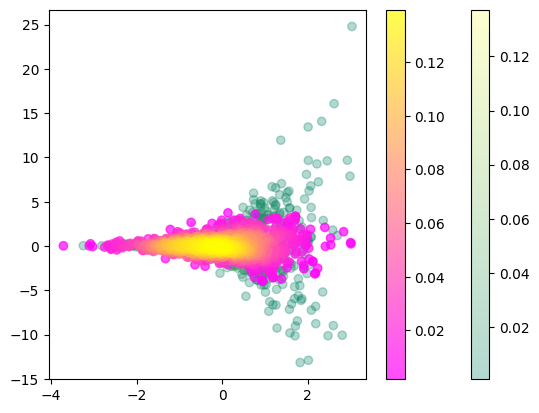

In [ ]:
# Now target
points = target.sample(1000)

# Generate points from distribution
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='summer', alpha=0.3)
plt.colorbar()

chains, _ = ISIR(
        proposal.sample((2, )),
        target,
        proposal,
        1000,
        BURN_IN,
        n_particles=100)

# Generate points from distribution
points = chains[:, 0]
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='spring', alpha=0.7)
plt.colorbar()

plt.show()
plt.close()

# TSC
## Affine

In [ ]:
def affine_transform(eps, loc, scale):
    return loc + scale * eps

def inverse_affine_transform(eps, loc, scale):
    return (eps - loc) / scale

### Banana

  0%|          | 0/1000 [00:00<?, ?it/s]

Sample: 100%|██████████| 200/200 [00:00, 330.52it/s, step size=8.48e-01, acc. prob=0.921]


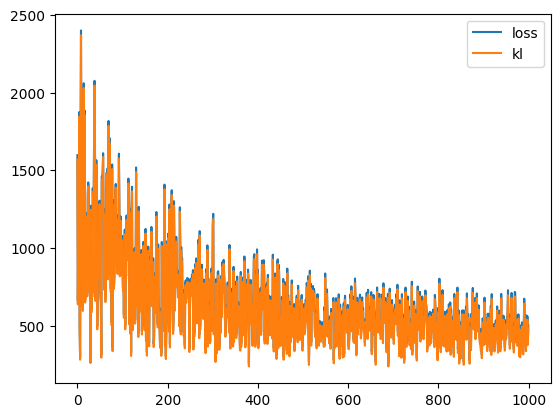

In [184]:
# define distributions
dim = 2
# define target
target = Banana(b=8e-3, dim=dim)
# define learnable parameters of proposal
# Pass to proposal like: proposal = MNormal(**learnable_params)
learnable_params = nn.ParameterDict({
    'loc': nn.Parameter(torch.zeros(dim), requires_grad=True),
    'scale' : nn.Parameter(torch.ones(1), requires_grad=True)
})


# define params for chain
N_CHAINS = 2
N_SAMPLES = 100
BURN_IN = 100

# optimizer
optimizer = optim.AdamW(lr=3e-3, params=learnable_params.parameters())
# decay lr: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR
scheduler = StepLR(optimizer, 1, gamma=1 - 1e-3)

# MSC iteration
n_iter = 1000

loss_arr = []
kl_arr = []


# first init
proposal = MNormal(learnable_params['loc'], torch.eye(dim) * (learnable_params['scale'] ** 2))
z_0 = proposal.sample((N_CHAINS, ))

for i in tqdm(range(n_iter)):

    optimizer.zero_grad()

    # define proposal with new params
    proposal = MNormal(learnable_params['loc'], torch.eye(dim) * (learnable_params['scale'] ** 2))

    # sample from it
    # with torch.no_grad():
        # chains, _ = ISIR(
        # z_0,
        # target,
        # proposal,
        # N_SAMPLES,
        # BURN_IN,
        # n_particles=100)

    chains = HMC(
        proposal.sample((N_CHAINS,)),
        target,
        N_SAMPLES,
        BURN_IN,
        step_size = 0.05,
        num_leapfrog_steps = 20,
        verbose = False)

    # функция тупая и не пашет с одной цепью
    chain = chains[:, 0].detach()

    z = affine_transform(chain, learnable_params['loc'], learnable_params['scale'])
    # get
    log_p = target.log_prob(chain)
    log_q = proposal.log_prob(chain)

    loss = (-1 * torch.exp(log_p) * log_q).sum()
    loss.backward()

    optimizer.step()

    scheduler.step()

    with torch.no_grad():
        loss_arr.append(loss.detach().item())
        kl_arr.append(KL_div(log_p, log_q))
        z_0 = inverse_affine_transform(z[:1], learnable_params['loc'], learnable_params['scale'])


plt.plot(loss_arr, label='loss')
plt.plot(kl_arr, label='kl')
plt.legend()
plt.show()

Sample: 100%|██████████| 1100/1100 [00:01, 594.90it/s, step size=6.52e-01, acc. prob=0.946]


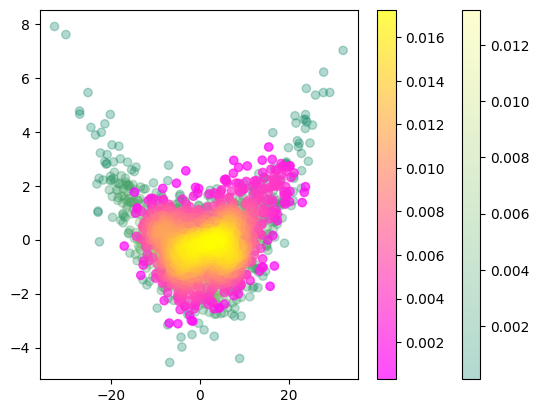

In [186]:
# Now target
points = target.sample(1000)

# Generate points from distribution
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='summer', alpha=0.3)
plt.colorbar()

chains = HMC(
        proposal.sample((N_CHAINS,)),
        target,
        1000,
        BURN_IN,
        step_size = 0.05,
        num_leapfrog_steps = 20,
        verbose = False)

# Generate points from distribution
points = chains[:, 0]
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='spring', alpha=0.7)
plt.colorbar()

plt.show()
plt.close()

### Funnel

  0%|          | 0/1000 [00:00<?, ?it/s]

Sample: 100%|██████████| 200/200 [00:01, 190.96it/s, step size=3.58e-01, acc. prob=0.844]


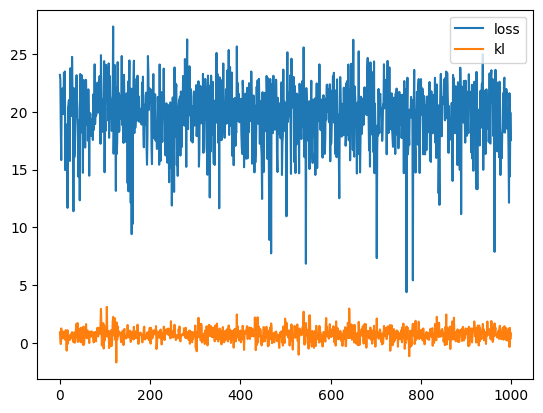

In [187]:
# define distributions
dim = 2
# define target
target = Funnel(num_dims=2)
# define learnable parameters of proposal
# Pass to proposal like: proposal = MNormal(**learnable_params)
learnable_params = nn.ParameterDict({
    'loc': nn.Parameter(torch.zeros(dim), requires_grad=True),
    'scale' : nn.Parameter(torch.ones(1), requires_grad=True)
})


# define params for chain
N_CHAINS = 2
N_SAMPLES = 100
BURN_IN = 100

# optimizer
optimizer = optim.AdamW(lr=3e-2, params=learnable_params.parameters())
# decay lr: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR
scheduler = StepLR(optimizer, 1, gamma=0.1)

# MSC iteration
n_iter = 1000

loss_arr = []
kl_arr = []


# first init
proposal = MNormal(learnable_params['loc'], torch.eye(dim) * (learnable_params['scale'] ** 2))
z_0 = proposal.sample((N_CHAINS, ))

for i in tqdm(range(n_iter)):

    optimizer.zero_grad()

    # define proposal with new params
    proposal = MNormal(learnable_params['loc'], torch.eye(dim) * (learnable_params['scale'] ** 2))

    chains = HMC(
        proposal.sample((N_CHAINS,)),
        target,
        N_SAMPLES,
        BURN_IN,
        step_size = 0.05,
        num_leapfrog_steps = 20,
        verbose = False)

    # функция тупая и не пашет с одной цепью
    chain = chains[:, 0].detach()


    z = affine_transform(chain, learnable_params['loc'], learnable_params['scale'])
    # get
    log_p = target.log_prob(chain)
    log_q = proposal.log_prob(chain)

    loss = (-1 * torch.exp(log_p) * log_q).sum()
    loss.backward()

    optimizer.step()

    scheduler.step()

    with torch.no_grad():
        loss_arr.append(loss.detach().item())
        kl_arr.append(KL_div(log_p, log_q))
        z_0 = inverse_affine_transform(z[:1], learnable_params['loc'], learnable_params['scale'])


plt.plot(loss_arr, label='loss')
plt.plot(kl_arr, label='kl')
plt.legend()
plt.show()

Sample: 100%|██████████| 1100/1100 [00:02, 490.99it/s, step size=6.61e-01, acc. prob=0.855]


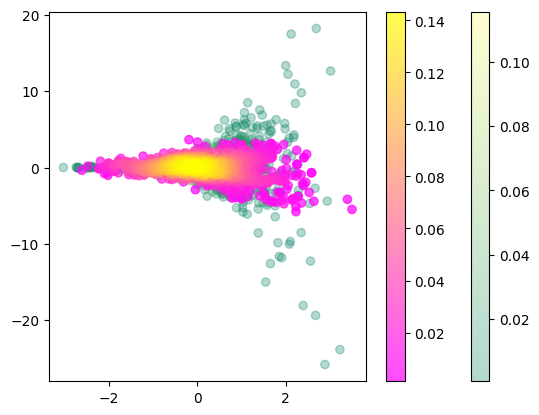

In [188]:
# Now target
points = target.sample(1000)

# Generate points from distribution
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='summer', alpha=0.3)
plt.colorbar()

chains = HMC(
        proposal.sample((N_CHAINS,)),
        target,
        1000,
        BURN_IN,
        step_size = 0.05,
        num_leapfrog_steps = 20,
        verbose = False)

# Generate points from distribution
points = chains[:, 0]
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='spring', alpha=0.7)
plt.colorbar()

plt.show()
plt.close()